In [1]:
import cometspy_virus as c
import cobra
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
covid_cobra = cobra.io.read_sbml_model('Models/iAB_AMO1410_SARS-CoV-2.xml')

Using license file /usr/local/gurobi/gurobi.lic
Set parameter TokenServer to value sccsvc


In [3]:
#ATP for virion production
atp_v = cobra.Metabolite(
    'atp_v',
    formula='C10H12N5O13P3',
    name='ATP C10H12N5O13P3',
    compartment='v')

#ATP for cell maintenance
atp_t = cobra.Metabolite(
    'atp_t',
    formula='C10H12N5O13P3',
    name='ATP C10H12N5O13P3',
    compartment='t')

#New VBOF
vbof = covid_cobra.reactions[3393]

vbofb = cobra.Reaction('VBOFb')
vbofb.name = 'VBOF secondary'
vbofb.lower_bound = 0
vbofb.upper_bound = 1000

new_coefficients = {'ala_DASH_L_c': -0.40405653355288423, 'arg_DASH_L_c': -0.2553326998866419, 'asn_DASH_L_c': -0.3658649996235405, 'asp_DASH_L_c': -0.2706103940814215, 'atp_c': 0, 'ctp_c': -0.040954609860685644, 'cys_DASH_L_c': -0.13700910801605434, 'gln_DASH_L_c': -0.2929221724068042, 'glu_DASH_L_c': -0.20130000403341305, 'gly_c': -0.40648021666164025, 'gtp_c': -0.040954609860685644, 'h2o_c': -22.996430209926125, 'his_DASH_L_c': -0.0758787256474576, 'ile_DASH_L_c': -0.32826780836736325, 'leu_DASH_L_c': -0.5351723866213741, 'lys_DASH_L_c': -0.2940830703034822, 'met_DASH_L_c': -0.07605185689627733, 'phe_DASH_L_c': -0.30802310754683687, 'pro_DASH_L_c': -0.27001913890266127, 'ser_DASH_L_c': -0.4616491104562987, 'thr_DASH_L_c': -0.42457524950194836, 'trp_DASH_L_c': -0.06972920866419034, 'tyr_DASH_L_c': -0.22709910729043886, 'utp_c': -0.06689789910647442, 'val_DASH_L_c': -0.37878770746009893, 'adp_c': 22.996430209926125, 'h_c': 22.996430209926125, 'pi_c': 22.996430209926125, 'ppi_c': 0.2156977623224659}
old_coefficients = {'ala_DASH_L_c': -0.523475047557154, 'arg_DASH_L_c': -0.330795596116271, 'asn_DASH_L_c': -0.473995655989129, 'asp_DASH_L_c' : -0.350589221829951, 'atp_c' : -29.8797022664371, 'ctp_c' : -0.0530586921574203, 'cys_DASH_L_c' : -0.177502469307259, 'gln_DASH_L_c' : -0.379494644083214, 'glu_DASH_L_c' : -0.2607936351114, 'gly_c' : -0.52661511282618, 'gtp_c' : -0.0530586921574203, 'h2o_c' : -29.793032726839, 'his_DASH_L_c' : -0.0983046028716697, 'ile_DASH_L_c' : -0.425287262589838, 'leu_DASH_L_c' : -0.69334229863586, 'lys_DASH_L_c' : -0.380999258691289, 'met_DASH_L_c' : -0.0985288932480286, 'phe_DASH_L_c' : -0.39905930670436, 'pro_DASH_L_c' : -0.349822896377391, 'ser_DASH_L_c' : -0.598088979425907, 'thr_DASH_L_c' : -0.550058129871867, 'trp_DASH_L_c' : -0.0903376217947519, 'tyr_DASH_L_c' : -0.294217573905061, 'utp_c' : -0.0866695395980478, 'val_DASH_L_c' : -0.490737998041092, 'adp_c' : 29.793032726839, 'h_c' : 29.793032726839, 'pi_c' : 29.793032726839, 'ppi_c' : 0.279447118078588}

for m in vbof.metabolites:
    vbof.add_metabolites({m: new_coefficients[str(m)] - old_coefficients[str(m)]})
    vbofb.add_metabolites({m: new_coefficients[str(m)]})
    
vbof.add_metabolites({atp_v: -23.063351651177445})
vbofb.add_metabolites({atp_t: -23.063351651177445})
    
sphmyln = covid_cobra.metabolites[1535]
pchol = covid_cobra.metabolites[1528]

vbof.add_metabolites({sphmyln: -0.20233837286384723, pchol: -0.20233837286384723})
vbofb.add_metabolites({sphmyln: -0.20233837286384723, pchol: -0.20233837286384723})

covid_cobra.add_reactions([vbofb])

#New ATP Maintenance Reaction (IS DIFF FROM ATPasel)
atpm = cobra.Reaction('ATPM')
atpm.name = 'ATP Maintenance'
atpm.lower_bound = 0.  # This is the default
atpm.upper_bound = 1000.  # This is the default

h2o_c = covid_cobra.metabolites[496]
adp_c = covid_cobra.metabolites[169]
h_c = covid_cobra.metabolites[494]
pi_c = covid_cobra.metabolites[702]

atpm.add_metabolites({
    atp_t: -1,
    h2o_c: -1,
    adp_c: 1,
    h_c: 1,
    pi_c: 1
})

covid_cobra.add_reactions([atpm])

#New Reaction to convert ATP_v into ATP_t
atpvconversion = cobra.Reaction('ATPVConversion')
atpvconversion.name = 'ATP_v Conversion'
atpvconversion.lower_bound = 0.  # This is the default
atpvconversion.upper_bound = 1000.  # This is the default

atpvconversion.add_metabolites({
    atp_v: -1,
    atp_t: 1
})

covid_cobra.add_reactions([atpvconversion])

#Partition the ATP

atppartition = cobra.Reaction('ATPpartition')
atppartition.name = 'ATP Partitioning'
atppartition.lower_bound = 0.  # This is the default
atppartition.upper_bound = 1000.  # This is the default

atp_c = covid_cobra.metabolites[225]

atppartition.add_metabolites({
    atp_c: -1,
    atp_v: 0.3,
    atp_t: 0.7
})
covid_cobra.add_reactions([atppartition])

In [4]:
covid = c.model(covid_cobra)

In [6]:
#MAKE PARAMETERS FOR THE ATP THRESHOLD AND THE PARTITION RATIO
    
covid.initial_pop = [0, 0, 5e-6]

covid.set_objective(['VBOF', 'ATPM', 'VBOFb'])

covid.change_biomass('BIOMASS_mac')
covid.change_maintenance('ATPM', 1)

covid.change_objective_style("MAX_OBJECTIVE_MIN_TOTAL")

covid.add_neutral_drift_parameter(1e-16)

test_tube = c.layout()
test_tube.add_model(covid)

test_tube.set_specific_static_at_location('arg_DASH_L_e', (0, 0), 19.9e-9)
test_tube.set_specific_static_at_location('glc_DASH_D_e', (0, 0), 500e-9) #500e-9
test_tube.set_specific_static_at_location('gln_DASH_L_e', (0, 0), 0)
test_tube.set_specific_static_at_location('his_DASH_L_e', (0, 0), 10e-9)
test_tube.set_specific_static_at_location('ile_DASH_L_e', (0, 0), 40.05e-9)
test_tube.set_specific_static_at_location('leu_DASH_L_e', (0, 0), 40.05e-9)
test_tube.set_specific_static_at_location('lys_DASH_L_e', (0, 0), 39.9e-9)
test_tube.set_specific_static_at_location('met_DASH_L_e', (0, 0), 10.05e-9)
test_tube.set_specific_static_at_location('o2_e', (0, 0), 1000)
test_tube.set_specific_static_at_location('h2o_e', (0, 0), 1000)
test_tube.set_specific_static_at_location('phe_DASH_L_e', (0, 0), 20e-9)
test_tube.set_specific_static_at_location('pi_e', (0, 0), 45e-9)
test_tube.set_specific_static_at_location('pyr_e', (0, 0), 0)
test_tube.set_specific_static_at_location('thr_DASH_L_e', (0, 0), 39.9e-9)
test_tube.set_specific_static_at_location('trp_DASH_L_e', (0, 0), 3.92e-9)
test_tube.set_specific_static_at_location('val_DASH_L_e', (0, 0), 40.15e-9)
 
# Set the parameters that are different from the default
sim_params = c.params()

sim_params.set_param('defaultVmax', 18.5) #Large value so it won't default to this
sim_params.set_param('defaultKm', 0.000015) #0.000015
sim_params.set_param('maxCycles', 1000)
sim_params.set_param('timeStep', 0.01)
sim_params.set_param('spaceWidth', 0.01)
sim_params.set_param('maxSpaceBiomass', 10)
sim_params.set_param('minSpaceBiomass', 1e-11)
sim_params.set_param('writeMediaLog', True)
sim_params.set_param('writeFluxLog', True)
sim_params.set_param('FluxLogRate', 1)
sim_params.set_param('MediaLogRate', 1)
    
experiment = c.comets(test_tube, sim_params)

building empty layout model
models will need to be added with layout.add_model()
/projectnb/cometsfba/comets_2.10.9_trial


In [7]:
experiment.run()


Running COMETS simulation ...


KeyboardInterrupt: 

In [ ]:
print(experiment.run_output)

In [9]:
experiment.total_biomass['cycle'] = experiment.total_biomass['cycle'] * 0.01
experiment.fluxes_by_species['macrophage_SARS_CoV_2']['cycle'] = experiment.fluxes_by_species['macrophage_SARS_CoV_2']['cycle'] * 0.01
experiment.media['cycle'] = experiment.media['cycle'] * 0.01

plt.rcParams['font.size'] = 20

In [10]:
#Calculate Virus Biomass
experiment.fluxes_by_species['macrophage_SARS_CoV_2']['VBOF'] += experiment.fluxes_by_species['macrophage_SARS_CoV_2']['VBOFb']

deltaT = 0.01

vb = pd.DataFrame(columns= ['cycle', 'virus mass'], dtype= float)
vb = vb.append({'cycle': 0, 'virus mass': 0}, ignore_index= True)

for i in range(0, len(experiment.fluxes_by_species['macrophage_SARS_CoV_2']['VBOF'])):
    t = i * deltaT
    vmass = (vb['virus mass'][len(vb['virus mass']) - 1]) + \
            (experiment.fluxes_by_species['macrophage_SARS_CoV_2']['VBOF'][i] * deltaT * \
             experiment.total_biomass['macrophage_SARS_CoV_2'][i])
    vb = vb.append({'cycle': t, 'virus mass': vmass}, ignore_index= True)

In [11]:
#Media
glcmedia = experiment.media.copy()
glcmedia = glcmedia[glcmedia.metabolite == 'glc_DASH_D_e']

In [12]:
allFluxes = experiment.fluxes_by_species['macrophage_SARS_CoV_2']

In [13]:
plt.rcParams['font.size'] = 15

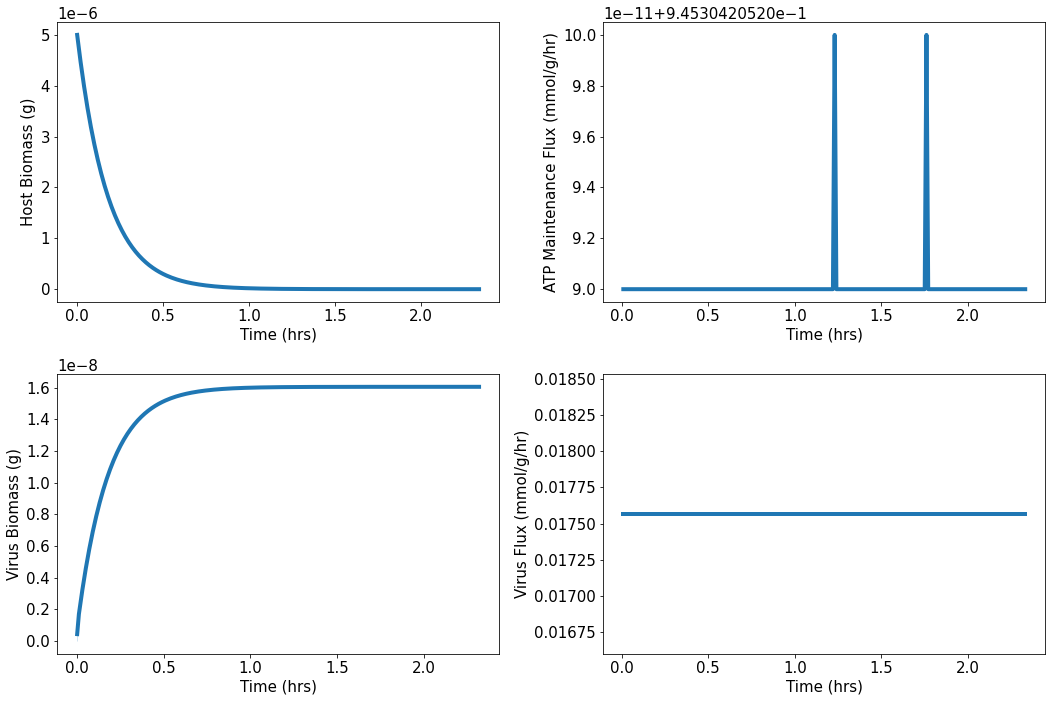

In [14]:
fig, axs = plt.subplots(ncols= 2, nrows= 2, figsize= (15, 10))

#------------------------------------------#

sns.lineplot(data= experiment.total_biomass, 
             x= 'cycle', y= 'macrophage_SARS_CoV_2', ax= axs[0][0], linewidth= 4)
axs[0][0].set_xlabel('Time (hrs)')
axs[0][0].set_ylabel('Host Biomass (g)')
#axs[0][0].set_xlim(0, 1)

#------------------------------------------#

sns.lineplot(data= vb, 
             x= 'cycle', y= 'virus mass', ax= axs[1][0], linewidth= 4)
axs[1][0].set_xlabel('Time (hrs)')
axs[1][0].set_ylabel('Virus Biomass (g)')
#axs[1][0].set_xlim(0, 1)

#------------------------------------------#

sns.lineplot(data= allFluxes, 
             x= 'cycle', y= 'ATPM', ax= axs[0][1], linewidth= 4)
axs[0][1].set_xlabel('Time (hrs)')
axs[0][1].set_ylabel('ATP Maintenance Flux (mmol/g/hr)')
#axs[0][1].set_xlim(0, 1)

#------------------------------------------#

sns.lineplot(data= allFluxes, 
             x= 'cycle', y= 'VBOF', ax= axs[1][1], linewidth= 4)
axs[1][1].set_xlabel('Time (hrs)')
axs[1][1].set_ylabel('Virus Flux (mmol/g/hr)')
#axs[1][1].set_xlim(0, 1)

plt.tight_layout()

In [15]:
data = pd.DataFrame()

data.insert(0, 'cycle', experiment.total_biomass['cycle'])
data.insert(1, 'host biomass', experiment.total_biomass['macrophage_SARS_CoV_2'])
data.insert(2, 'virus mass', vb['virus mass'])
data.insert(3, 'ATPM', allFluxes['ATPM'])
data.insert(4, 'VBOF', allFluxes['VBOF'])

In [16]:
data

,cycle,host biomass,virus mass,ATPM,VBOF
0,0.00,5.000000e-06,0.000000e+00,0.945304,0.017566
1,0.01,4.726521e-06,8.782990e-10,0.945304,0.017566
2,0.02,4.468000e-06,1.708559e-09,0.945304,0.017566
3,0.03,4.223619e-06,2.493407e-09,0.945304,0.017566
4,0.04,3.992605e-06,3.235327e-09,0.945304,0.017566
...,...,...,...,...,...
230,2.30,1.203471e-11,1.605785e-08,0.945304,0.017566
231,2.31,1.137646e-11,1.605785e-08,0.945304,0.017566
232,2.32,1.075422e-11,1.605785e-08,0.945304,0.017566
233,2.33,1.016601e-11,1.605786e-08,NaN,NaN


In [104]:
fig.savefig('filename.jpg', format='jpg')